In [1]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar

from tqdm.notebook import tqdm

from scipy.ndimage import gaussian_filter, gaussian_filter1d

from qsa_pwfa.simulation import Simulation    
from qsa_pwfa.utils import get_density, get_field, get_Psi_new_grid

n_plasma = 1e17 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

In [2]:
"""
CASE 1

nb/n0 = 5
kp*sigma_r = 0.1
kp_sigma_z = 1r_axis
Lambda = 0.05)
"""

# Beam 
n_b = 5.
R_b = 0.1
ksi0 = 5
R_xi = 1

# plasma
L_xi = 18
L_r = 10.0/4

# grid
N_xi = 512

d_xi = L_xi/N_xi
dr = 0.1*d_xi

N_r = int(np.ceil(L_r/dr / 4)*4)
L_r = N_r * dr
n_b * (2*np.pi)**1.5 * (k_p_inv*R_b)**2 * (k_p_inv*R_xi) * 1e23 * e * 1e12

59.87392327012325

In [3]:
sim = Simulation(L_xi=L_xi, N_xi=N_xi, L_r=L_r, N_r=N_r)
sim.init_beam(n_b, R_b, ksi0, R_xi)
sim.advance_xi(0)

%timeit sim.advance_xi(0)

11.7 ms ± 31.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
sim = Simulation(L_xi=L_xi, N_xi=N_xi, L_r=L_r, N_r=N_r)
sim.init_beam(n_b, R_b, ksi0, R_xi)

r_xi = np.zeros((sim.N_xi, sim.N_r))
vz_xi = np.zeros((sim.N_xi, sim.N_r))
phi_xi = np.zeros((sim.N_xi, sim.N_r))


r_xi[0] = sim.r
vz_xi[0] = sim.v_z

for i_xi in tqdm(range(N_xi-1)):
    sim.advance_xi(i_xi)
    r_xi[i_xi+1] = sim.r
    vz_xi[i_xi+1] = sim.v_z
    phi_xi[i_xi+1] = sim.Psi

  0%|          | 0/511 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


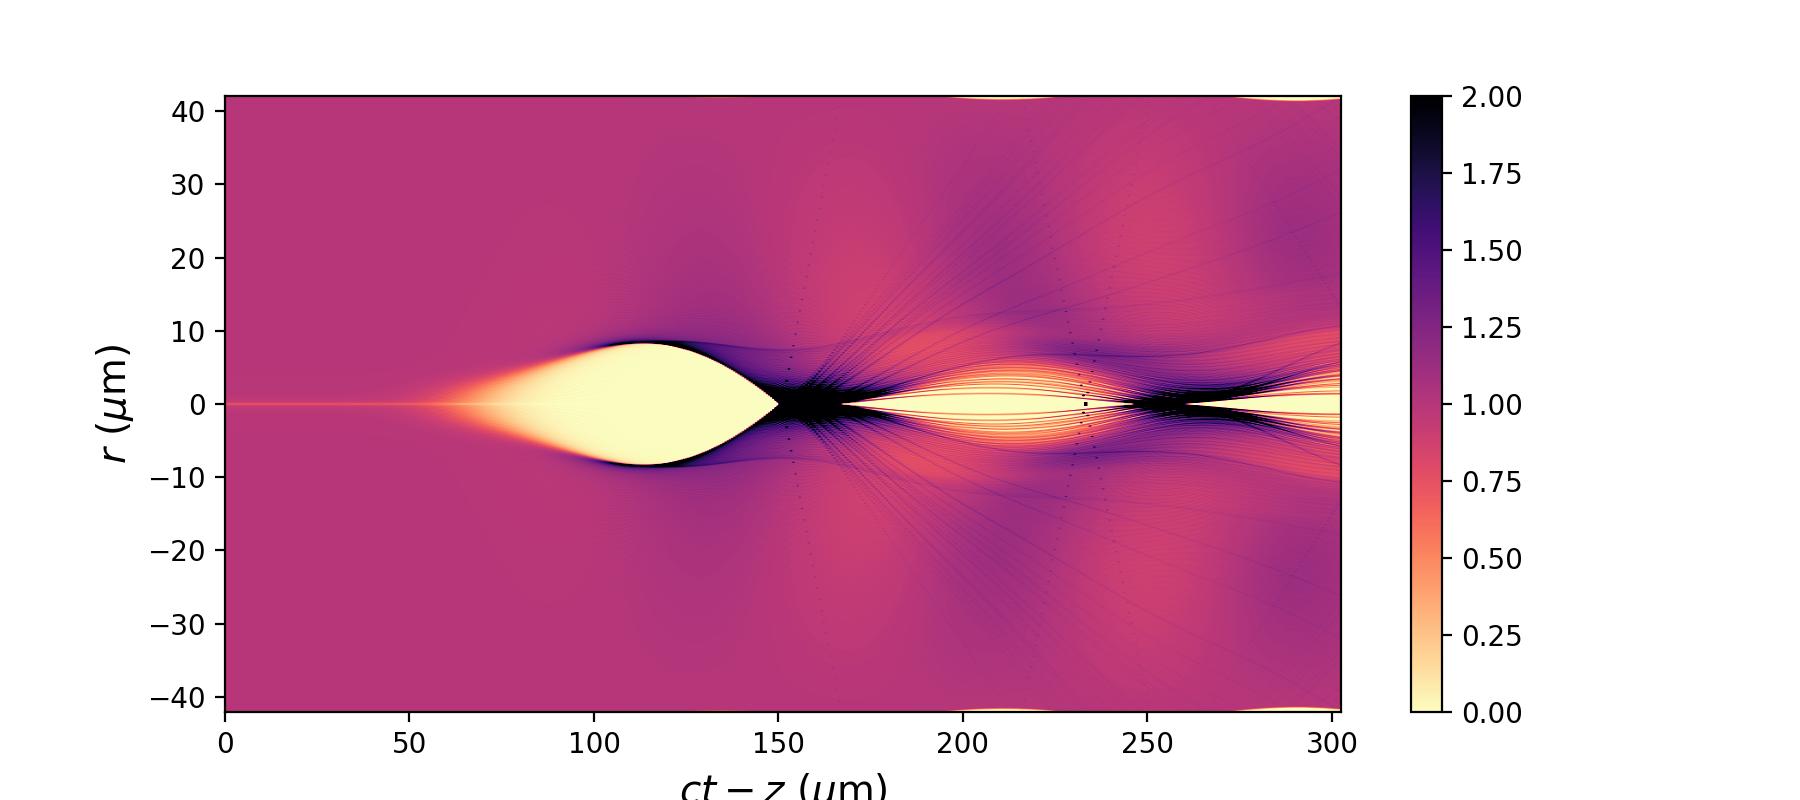

<ipython-input-12-8b8ebd4a857f>:30: RuntimeWarning: invalid value encountered in true_divide
  val = np.nan_to_num(gaussian_filter(field_dens/dens, 0.5))


<IPython.core.display.Javascript object>


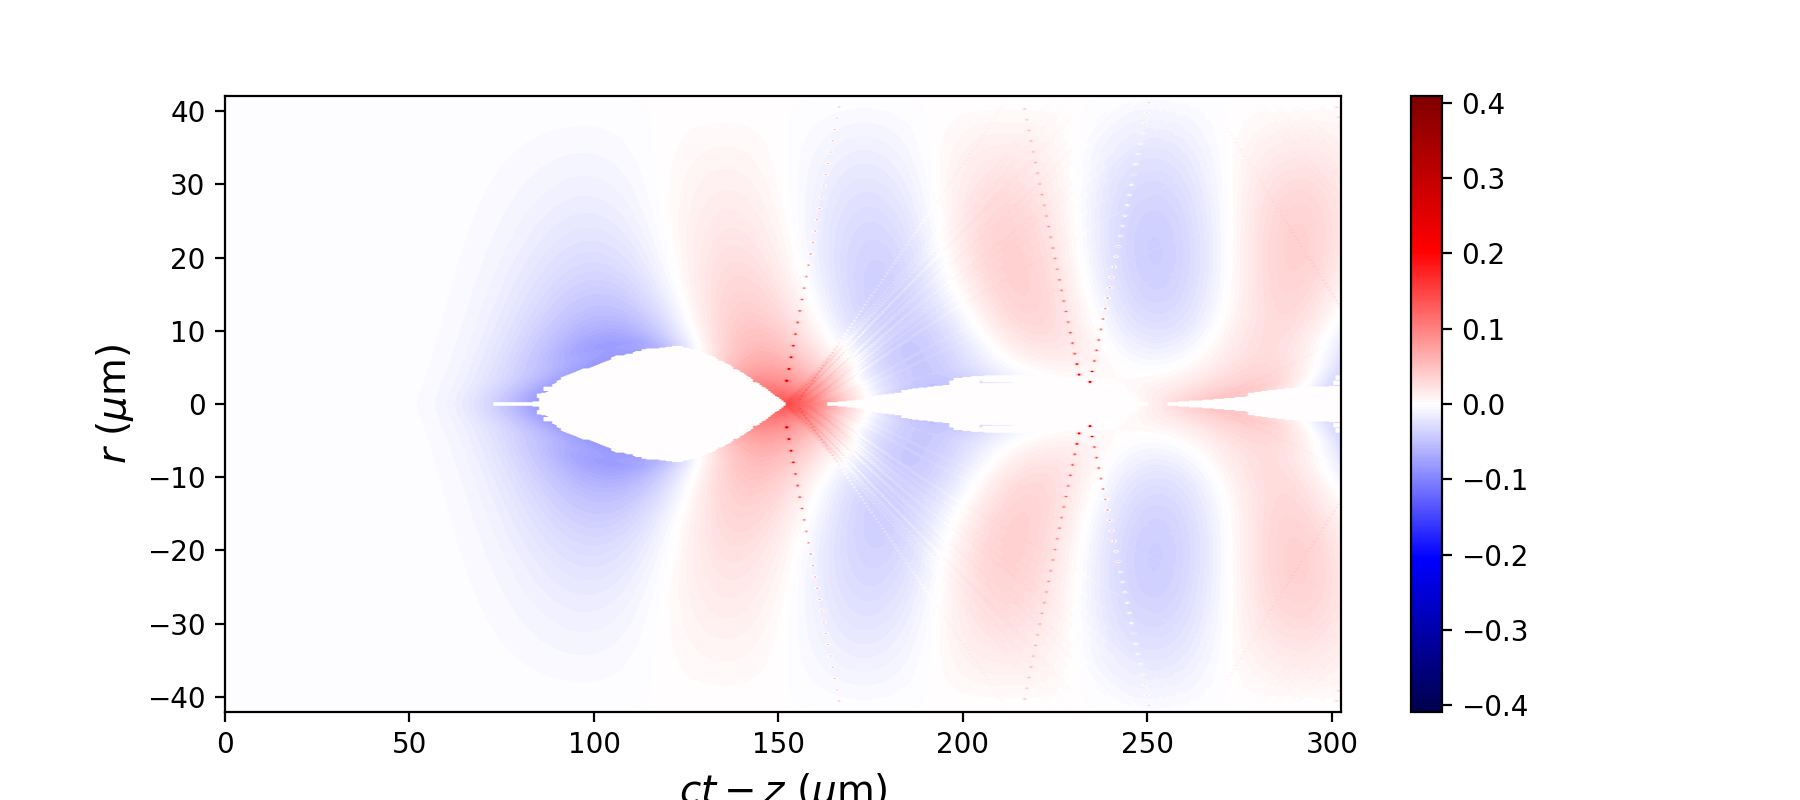

<IPython.core.display.Javascript object>


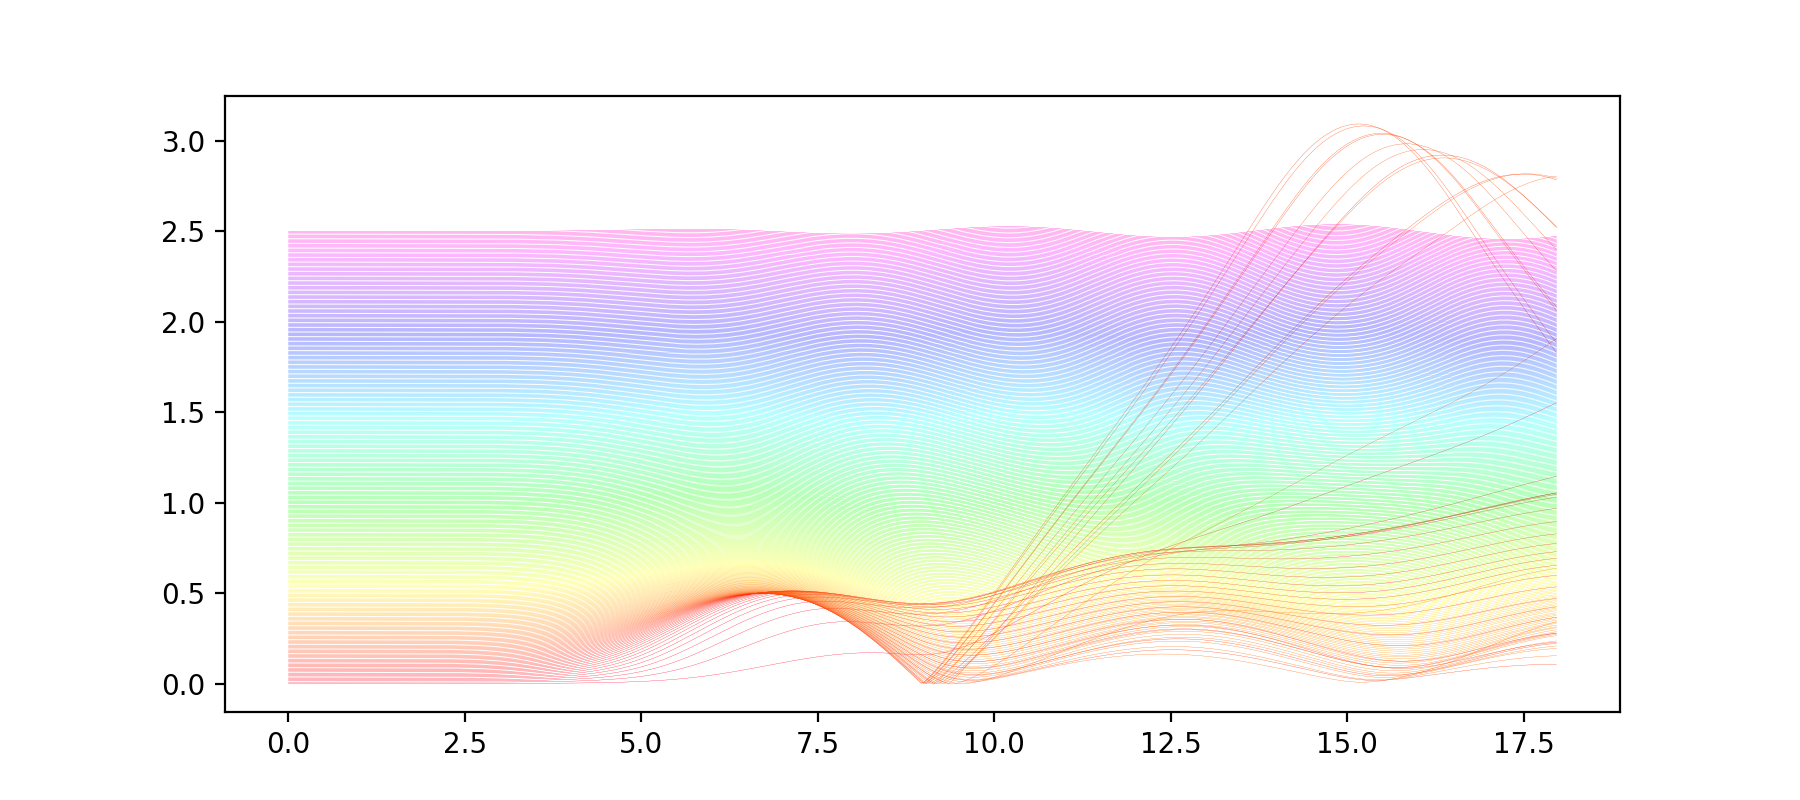

In [12]:
Nr_new = sim.N_r//2
dr_proj = L_r/Nr_new

dens = get_density(r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
dens_ext = np.hstack((dens[:,1:][:,::-1], dens[:,1:]))

ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) * k_p_inv * 1e6

#ext[:2] -= k_p_inv * 1e6

plt.figure(figsize=(9,4))

plt.imshow(dens_ext.T,
           origin='lower',
           aspect='auto',
           cmap=plt.cm.magma_r,
           vmax=2,
           extent=ext
          )
plt.colorbar()
plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)


for field_val in [vz_xi, ]:
# for field_val in [vz_xi, , dAz_dr_xi, dPsi_dr_xi]:

    dens = get_density(r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    field_dens = get_field(field_val, r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    val = np.nan_to_num(gaussian_filter(field_dens/dens, 0.5))    
    val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))

    #field_dens_ext = np.hstack((field_dens[:,1:][:,::-1], field_dens[:,1:]))

    #ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) * k_p_inv * 1e6
    
    plt.figure(figsize=(9,4))

    vmax = np.abs( val.max() )    
    plt.imshow(val_ext.T, origin='lower', 
               aspect='auto', cmap=plt.cm.seismic,
               #vmax=4, 
               vmax=vmax, vmin=-vmax,
               extent=ext)

    plt.colorbar()
    plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
    plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)

#plt.savefig('QSA_PWFA_case2.pdf')
#plt.savefig('QSA_PWFA_case2.jpg')



plt.figure(figsize=(9,4))

Nr_plot =   sim.N_r

myrainbow = matplotlib.cm.get_cmap('gist_rainbow', Nr_plot)

for j in range(Nr_plot)[::2]:
    #plt.plot(r_xi[:N_xi][1:, j] - r_xi[:N_xi][-1, j], color=myrainbow(j/Nr_plot))
    plt.plot(sim.xi, r_xi[:, j], color=myrainbow(j/Nr_plot), lw=0.1)


#plt.savefig('QSA_PWFA_case1.pdf')
#plt.savefig('QSA_PWFA_case1.jpg')

In [6]:
Phi_new = np.zeros_like(r_xi)

for i_xi in range(N_xi-1):
    Phi_new[i_xi,:] = get_Psi_new_grid(Phi_new[i_xi,:], sim.r0, r_xi[i_xi],  sim.r0, sim.dV)

<IPython.core.display.Javascript object>


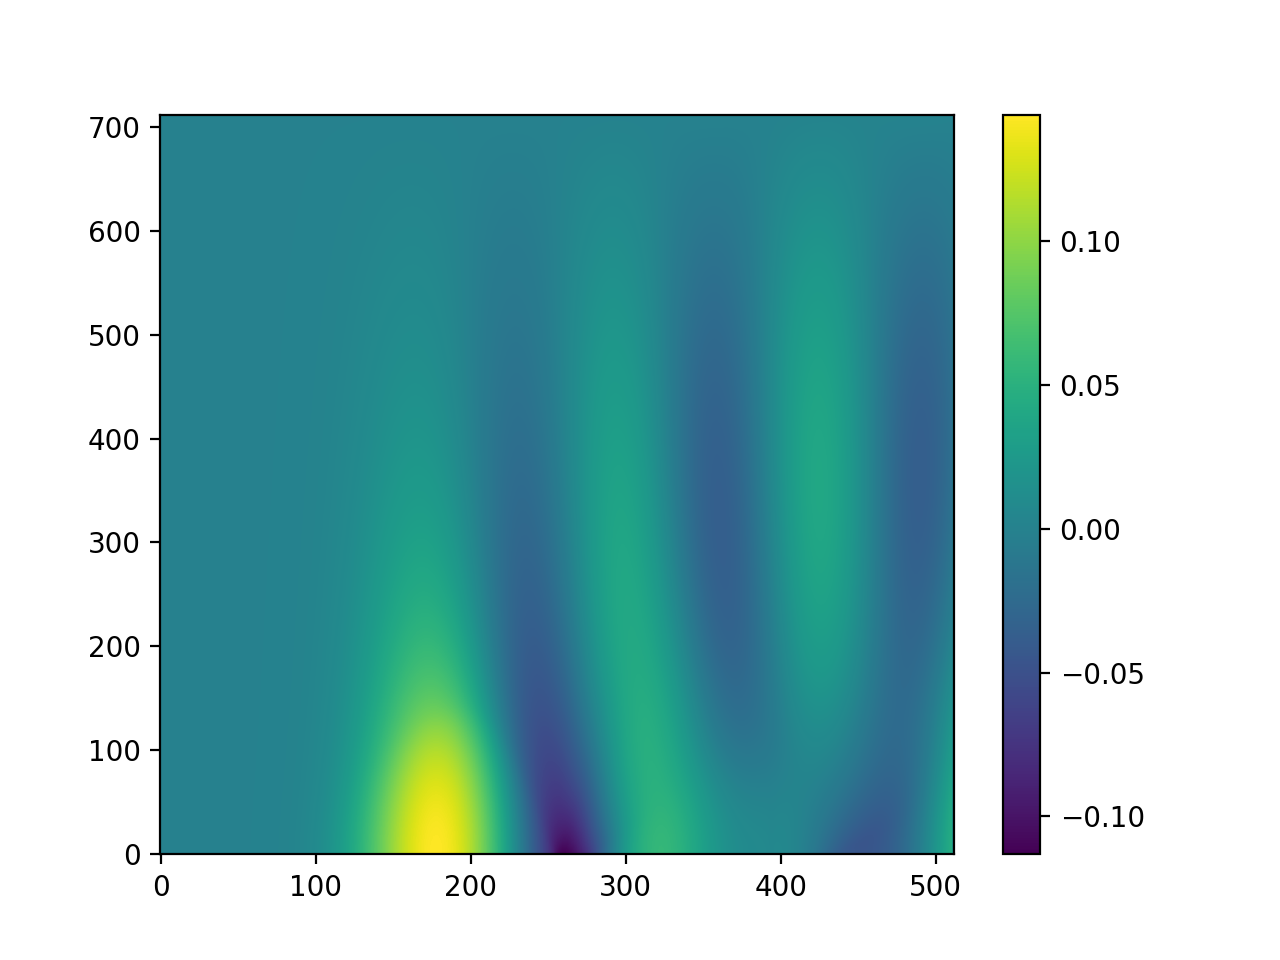

In [7]:
plt.figure()
plt.imshow(Phi_new.T, origin='lower', aspect='auto')
plt.colorbar()

In [8]:
dphi_dxi=np.zeros_like(r_xi)
dphi_dr=np.zeros_like(r_xi)
for j in range(N_r):
    dphi_dxi[1:-1, j] = 0.5 *( Phi_new[2:, j]-Phi_new[:-2, j]) / d_xi

for i in range(N_xi-1):
    dphi_dr[i, 1:-1] = 0.5 *( Phi_new[i, 2:]-Phi_new[i, :-2]) / dr

<IPython.core.display.Javascript object>


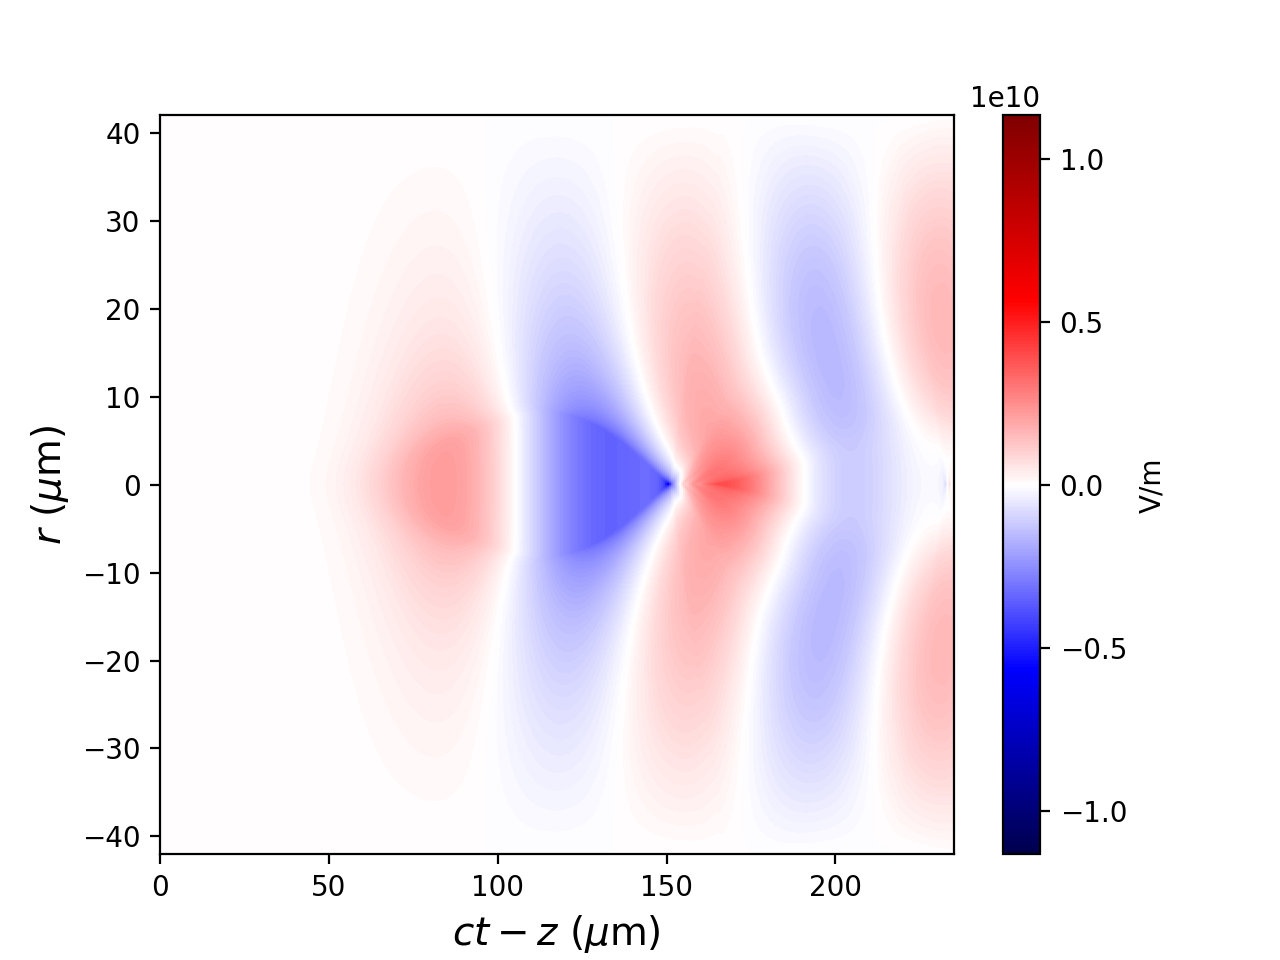

In [9]:
plt.figure()
vmax = 0.6 * np.max(np.abs(dphi_dxi))*field_dim

Ez_ext = np.hstack((dphi_dxi[:,1:][:,::-1], dphi_dxi[:,1:]))

ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) * k_p_inv * 1e6

plt.imshow((Ez_ext.T*field_dim), origin='lower', 
           cmap='seismic', extent=ext, vmin=-vmax, vmax=vmax,
           aspect='auto')

plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)
plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
plt.xlim(0, 235)

plt.colorbar(label='V/m')

#plt.figure()
#vmax = np.max(np.abs(dphi_dr))
#plt.imshow(dphi_dr.T, origin='lower', cmap='seismic', vmax=vmax, vmin=-vmax)
#plt.colorbar()

<IPython.core.display.Javascript object>


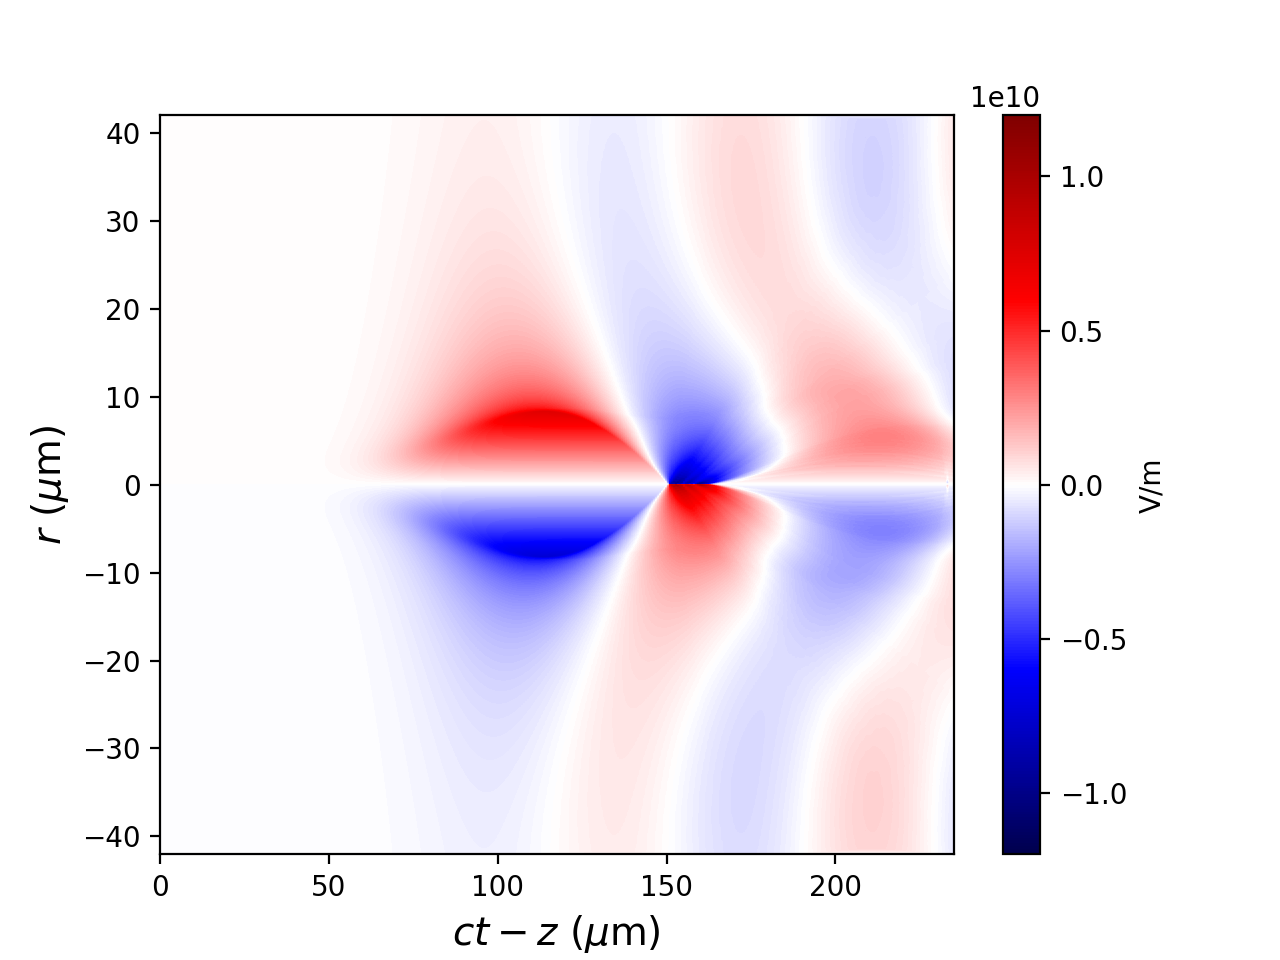

In [10]:
plt.figure()
vmax = np.max(np.abs(dphi_dr))*field_dim

dphi_dr_ext = np.hstack((-dphi_dr[:,1:][:,::-1], dphi_dr[:,1:]))

ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) * k_p_inv * 1e6

plt.imshow(-dphi_dr_ext.T*field_dim, origin='lower', cmap='seismic',
           vmax=vmax, vmin=-vmax, extent=ext, aspect='auto')
plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)
plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
plt.xlim(0, 235)

plt.colorbar(label='V/m')

In [5]:
"""
CASE 2

nb/n0 = 40
kp*sigma_r = 0.25
kp_sigma_z = 1
Lambda = 2.5
"""

# Beam 
n_b = 40 / 2.5
R_b = 0.25

ksi0 = 5
R_xi = 1

# plasma
L_xi = 18
L_r = 11

# grid
N_xi = 512*4

d_xi = L_xi/N_xi
dr = 0.2*d_xi

N_r = int(np.ceil(L_r/dr / 4)*4)
L_r = N_r * dr

print(N_r, n_b * (2*np.pi)**1.5 * (k_p_inv*R_b)**2 * (k_p_inv*R_xi) * 1e23 * e * 1e12)

6260 1197.4784654024647


In [6]:
sim = Simulation(L_xi=L_xi, N_xi=N_xi, L_r=L_r, N_r=N_r)
sim.init_beam(n_b, R_b, ksi0, R_xi)

r_xi = np.zeros((sim.N_xi, sim.N_r))
vz_xi = np.zeros((sim.N_xi, sim.N_r))

Psi_xi = np.zeros((sim.N_xi, sim.N_r))
dAz_dr_xi = np.zeros((sim.N_xi, sim.N_r))
dPsi_dr_xi = np.zeros((sim.N_xi, sim.N_r))


r_xi[0] = sim.r
vz_xi[0] = sim.v_z
    
for i_xi in tqdm(range(N_xi-1)):
    sim.advance_xi(i_xi)
    r_xi[i_xi+1] = sim.r
    
    vz_xi[i_xi+1] = sim.v_z
    Psi_xi[i_xi+1] = sim.Psi
    #dAz_dr_xi[i_xi+1] = sim.dAz_dr
    #dPsi_dr_xi[i_xi+1] = sim.dPsi_dr

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2047/2047 [21:35<00:00,  1.58it/s]


In [5]:
Nr_new = sim.N_r//2
dr_proj = L_r/Nr_new

dens = get_density(r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
dens_ext = np.hstack((dens[:,1:][:,::-1], dens[:,1:]))

ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) * k_p_inv * 1e6

plt.figure(figsize=(9,4))

plt.imshow(dens_ext.T, origin='lower', 
           aspect='auto', cmap=plt.cm.magma_r,
           vmax=4, 
           extent=ext)

plt.ylim(-8 * k_p_inv*1e6, 8* k_p_inv*1e6)
plt.xlim(0, 17* k_p_inv*1e6)
plt.title(f'QSA_PWFA simulation')

plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)

#plt.savefig('QSA_PWFA_case2.pdf')
#plt.savefig('QSA_PWFA_case2.jpg')

TypeError: Failed in nopython mode pipeline (step: convert to parfors)
object of type 'NoneType' has no len()

/tmp/ipykernel_7588/93806959.py:9: RuntimeWarning: invalid value encountered in true_divide
  val = np.nan_to_num(gaussian_filter(field_dens/dens, 0.5))


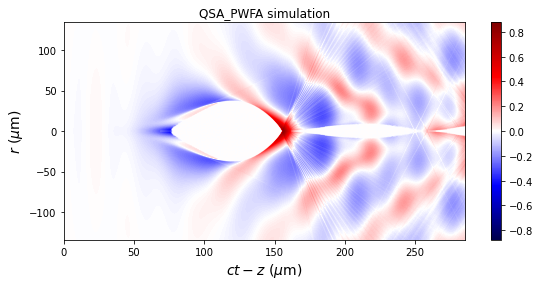

In [9]:
Nr_new = sim.N_r//3
dr_proj = L_r/Nr_new

for field_val in [vz_xi, ]:
# for field_val in [vz_xi, , dAz_dr_xi, dPsi_dr_xi]:

    dens = get_density(r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    field_dens = get_field(field_val, r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    val = np.nan_to_num(gaussian_filter(field_dens/dens, 0.5))    
    val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))

    #field_dens_ext = np.hstack((field_dens[:,1:][:,::-1], field_dens[:,1:]))

    ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) * k_p_inv * 1e6
    
    plt.figure(figsize=(9,4))

    vmax = np.abs( val.max() )    
    plt.imshow(val_ext.T, origin='lower', 
               aspect='auto', cmap=plt.cm.seismic,
               #vmax=4, 
               vmax=vmax, vmin=-vmax,
               extent=ext)

    plt.colorbar()
    plt.ylim(-8 * k_p_inv*1e6, 8* k_p_inv*1e6)
    #plt.ylim(-1.5 * k_p_inv*1e6, 1.5* k_p_inv*1e6)
    plt.xlim(0, 17* k_p_inv*1e6)
    plt.title(f'QSA_PWFA simulation')

    plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
    plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)

#plt.savefig('QSA_PWFA_case2.pdf')
#plt.savefig('QSA_PWFA_case2.jpg')